In [8]:
import warnings
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
import pandas as pd

# Loading our dataset

In [9]:
data = pd.read_csv('BTC-USD.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,1.029120e+10
1,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,1.684660e+10
2,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,1.687190e+10
3,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,2.178320e+10
4,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,2.384090e+10


In [10]:
data.dropna(inplace=True)

# Extracting features to be used

In [11]:
dataset = data[['Close','Open','High','Low']]
dataset = dataset.to_numpy()

In [12]:

show=True
plot_type = False

#Observations for testing kept aside

NUM_TEST = 100

#latency 

K = 50
NUM_ITERS=10000

labels = ['Close','Open','High','Low']
likelihood_vect = np.empty([0,1])

bic_vect = np.empty([0,1])

# Possible number of states in Markov Model
STATE_SPACE = range(1,25)

#Evaluation metric 
# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])

In [13]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

predicted_stock_data = np.empty([0,dataset.shape[1]])
likelihood_vect = np.empty([0,1])
bic_vect = np.empty([0,1])
for states in STATE_SPACE:

#Computing the number of parameters that will be fed in the GaussianHMM Model by using the formula '𝑁^2+2N-1'
    
    num_params = states**2 + 2*states-1

    model = hmm.GaussianHMM(n_components=states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS)


    model.fit(dataset[NUM_TEST:,:])

    likelihood_vect = np.vstack((likelihood_vect, model.score(dataset)))
    
#  Computing the BIC as the criteria for model selection

    bic_vect = np.vstack((bic_vect, -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])))

# Formula for computing the optimal number of states

opt_states = np.argmin(bic_vect) + 2

print('The Optimum number of states to be considered are {}'.format(opt_states))


C:\Users\Aime Munezero\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


The Optimum number of states to be considered are 15


# Graphs showing how HMM has been used to estimate the first 100 values of the data through forecasting the close, Low, High and Open prices.

MAPE for close, open, high and Low bitcoin prices are as follows : [0.06068909 0.05813403 0.04661702 0.05911453] 


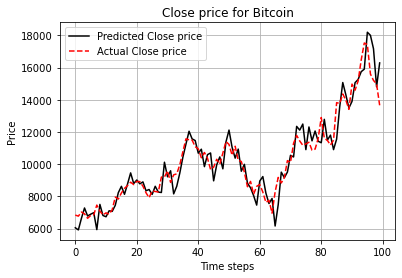

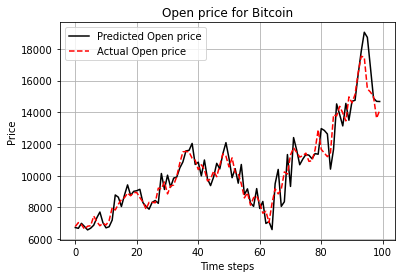

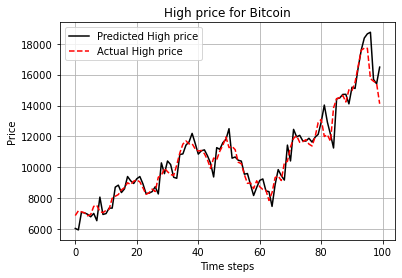

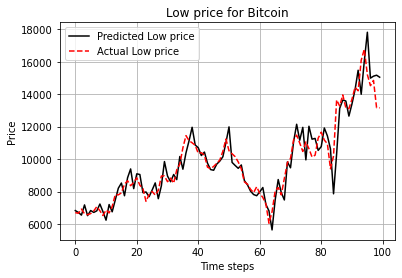

In [14]:
for idx in reversed(range(NUM_TEST)):

    train_dataset = dataset[idx + 1:,:]
    test_data = dataset[idx,:]
    num_examples = train_dataset.shape[0]
    
    #model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', startprob_prior=dirichlet_params, transmat_prior=dirichlet_params, tol=0.0001, n_iter=NUM_ITERS, init_params='mc')


    if idx == NUM_TEST - 1:
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='stmc')
    else:
        
    # Retuning the model by using the HMM paramters from the previous iterations as the prior
        
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='')
        model.transmat_ = transmat_retune_prior 
        model.startprob_ = startprob_retune_prior
        model.means_ = means_retune_prior
        model.covars_ = covars_retune_prior

    model.fit(np.flipud(train_dataset))

#  transmat_ (array, shape (n_components, n_components)) – Matrix of transition probabilities between states.

    transmat_retune_prior = model.transmat_

#  startprob_ (array, shape (n_components, )) – Initial state occupation distribution.

    startprob_retune_prior = model.startprob_
     
    means_retune_prior = model.means_
    covars_retune_prior = model.covars_

    if model.monitor_.iter == NUM_ITERS:
        print('Increase number of iterations')
        sys.exit(1)

    iters = 1
    past_likelihood = []

    curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))

    while iters < num_examples / K - 1:
        past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
        iters = iters + 1
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
    predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))

mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(100),:]))
print('MAPE for close, open, high and Low bitcoin prices are as follows : {} '.format(mape))


if PLOT_TYPE:
    hdl_p = plt.plot(range(100), predicted_stock_data);
    plt.title('Predicted bitcoin prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.figure()
    hdl_a = plt.plot(range(100),np.flipud(dataset[range(100),:]))
    plt.title('Actual bitcoin prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
else:
    for i in range(4):
        plt.figure()
        plt.plot(range(100), predicted_stock_data[:,i],'k-', label = 'Predicted '+labels[i]+' price');
        plt.plot(range(100),np.flipud(dataset[range(100),i]),'r--', label = 'Actual '+labels[i]+' price')
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        plt.title(labels[i]+' price'+ ' for '+"Bitcoin")
        plt.grid(True)
        plt.legend(loc = 'upper left')        

if PLOT_SHOW:
    plt.show(block=False)